The grading will center around 5 main points:

- [] Does the report include a section describing the data?

- [] Does the report include a paragraph detailing the main objective(s) of this analysis?  

- [] Does the report include a section with variations of classifier models and specifies which one is the model that best suits the main objective(s) of this analysis?

- [] Does the report include a clear and well presented section with key findings related to the main objective(s) of the analysis?

- [] Does the report highlight possible flaws in the model and a plan of action to revisit this analysis with additional data or different predictive modeling techniques? 

# A. Introduction
**This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.**
* sex: female or male
* age: of the patient.
* classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
* degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
* patient type: hospitalized or not hospitalized.
* pneumonia: whether the patient already have air sacs inflammation or not.
* pregnancy: whether the patient is pregnant or not.
* diabetes: whether the patient has diabetes or not.
* copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
* asthma: whether the patient has asthma or not.
* inmsupr: whether the patient is immunosuppressed or not.
* hypertension: whether the patient has hypertension or not.
* cardiovascular: whether the patient has heart or blood vessels related disease.
* renal chronic: whether the patient has chronic renal disease or not.
* other disease: whether the patient has other disease or not.
* obesity: whether the patient is obese or not.
* tobacco: whether the patient is a tobacco user.
* usmr: Indicates whether the patient treated medical units of the first, second or third level.
* medical unit: type of institution of the National Health System that provided the care.
* intubed: whether the patient was connected to the ventilator.
* icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
* death: indicates whether the patient died or recovered.

**The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not.**

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [92]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import StratifiedShuffleSplit

In [93]:
df = pd.read_csv("covid19_data.csv")

In [5]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

# B. Data Processing
1. Description already stated: _In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data._, we will eliminate all "missing data"

In [45]:
df.nunique()

USMER                     2
MEDICAL_UNIT             13
SEX                       2
PATIENT_TYPE              2
DATE_DIED               401
INTUBED                   4
PNEUMONIA                 3
AGE                     121
PREGNANT                  4
DIABETES                  3
COPD                      3
ASTHMA                    3
INMSUPR                   3
HIPERTENSION              3
OTHER_DISEASE             3
CARDIOVASCULAR            3
OBESITY                   3
RENAL_CHRONIC             3
TOBACCO                   3
CLASIFFICATION_FINAL      7
ICU                       4
dtype: int64

First, look into SEX columns:

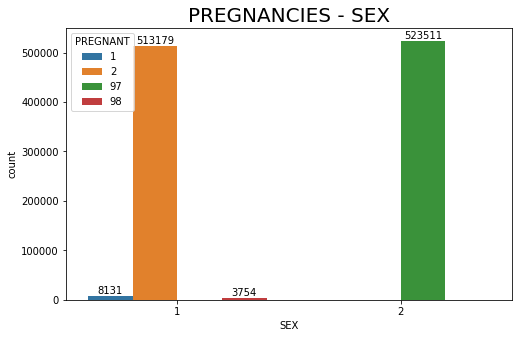

In [46]:
plt.figure(figsize = (8,5))
ax = sns.countplot(df.SEX, hue = df.PREGNANT)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("PREGNANCIES - SEX", fontsize = 20);

**In pregnancies, 98 means null values for female and 97 means null values for males. We will convert 97 to 2 because men can't birth.**

In [47]:
df.PREGNANT = df.PREGNANT.replace(97, 2)

Moreover, we look into INTUBED and ICU:

In [48]:
df.INTUBED.value_counts(normalize=True)

97    0.809235
2     0.151682
1     0.032097
99    0.006986
Name: INTUBED, dtype: float64

In [49]:
df.ICU.value_counts(normalize=True)

97    0.809235
2     0.167546
1     0.016077
99    0.007141
Name: ICU, dtype: float64

Most of them (**80.9%**) are missing data. So they should be drop. 

In [50]:
df.drop("INTUBED", axis = 1, inplace = True)
df.drop("ICU", axis = 1, inplace = True)

The other ones that still have missing value are:

In [51]:
contains_missing_value_cols = df.loc[:, df.nunique() == 3].columns

In [52]:
for col in contains_missing_value_cols:
    df = df[(df[col] == 1) | (df[col] == 2)]

With the objective: predict whether the patient is in high risk or not given the current status of the patients, DATE_DIED doesn't tell us a lot of information. Therefore, it would be dropped either.

In [53]:
df.drop("DATE_DIED", axis = 1, inplace = True)

Now, look into target class CLASIFFICATION_FINAL:

In [54]:
df.CLASIFFICATION_FINAL.value_counts()

7    488706
3    377378
6    117342
5     25245
1      8417
4      3088
2      1801
Name: CLASIFFICATION_FINAL, dtype: int64

We know that: **1-2-3 means COVID and 4-5-6-7 means not COVID**. So we convert like that:

In [55]:
df.CLASIFFICATION_FINAL = df.CLASIFFICATION_FINAL.replace([1,2,3], 0)
df.CLASIFFICATION_FINAL = df.CLASIFFICATION_FINAL.replace([4,5,6,7], 1)

In [72]:
feature_cols = df.columns[df.columns != 'CLASIFFICATION_FINAL']

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=7)

train_idx, test_idx = next(strat_shuf_split.split(df[feature_cols], df.CLASIFFICATION_FINAL))

# Create the dataframes
train_set = df.iloc[train_idx]
test_set = df.iloc[test_idx]
X_train = train_set[feature_cols]
y_train = train_set['CLASIFFICATION_FINAL']

X_test  = test_set[feature_cols]
y_test  = test_set['CLASIFFICATION_FINAL']

In [95]:
from sklearn.model_selection import GridSearchCV
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    results_pos['roc_auc_score'] = roc_auc_score(yt, yp)
    return results_pos

def general_report(model, name, param_grid = dict(), cv = 3, scoring = 'accuracy'):
    # The grid search object
    grid = GridSearchCV(model, 
                          param_grid=param_grid, 
                          scoring=scoring, cv = cv,
                          n_jobs=-1)

    # Do the grid search
    grid = grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    print(f"___{name} Model Report___")
    print(evaluate_metrics(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    _, ax = plt.subplots()
    sns.heatmap(cm, ax=ax, annot=True, fmt='d');
    ax.set(title=name);
    

## Logistic Regression Model

___Logistic Regression Model Report___
{'accuracy': 0.659977038037274, 'recall': 0.9092031631768384, 'precision': 0.6655089921693512, 'f1score': 0.7684996635718235, 'roc_auc_score': 0.5806346572082646}
              precision    recall  f1-score   support

           0       0.63      0.25      0.36    116279
           1       0.67      0.91      0.77    190315

    accuracy                           0.66    306594
   macro avg       0.65      0.58      0.56    306594
weighted avg       0.65      0.66      0.61    306594



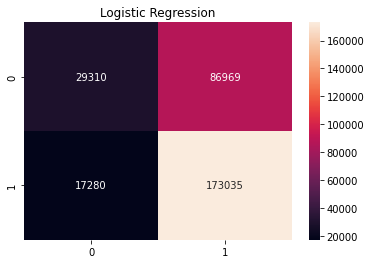

In [89]:
lr = LogisticRegression(solver='liblinear')
general_report(lr, name="Logistic Regression", cv=4)

In [ ]:
knn = KNeighborsClassifier(weights='distance')
param_grid = {
    "n_neighbors": [i for i in range(1, 39, 2)]
}
general_report(knn, name="K Nearest Neighboor", param_grid=param_grid)